# Init for pyqcu.

In [1]:
import cupy as cp
import numpy as np
import functools
from pyqcu.cuda import define, io, qcu, eigen, cg, bistabcg, amg, linalg, gauge, demo
from time import perf_counter
from opt_einsum import contract
from pyqcu.cuda.set import params, argv
params[define._LAT_X_] = 4
params[define._LAT_Y_] = 4
params[define._LAT_Z_] = 4
params[define._LAT_T_] = 4
params[define._LAT_XYZT_] = params[define._LAT_X_] * \
    params[define._LAT_Y_] * params[define._LAT_Z_] * params[define._LAT_T_]
params[define._DATA_TYPE_] = define._LAT_C64_
sigma = 1.0
seed = 12138
params[define._NODE_RANK_] = define.rank
params[define._NODE_SIZE_] = define.size
argv[define._TOL_] = 1e-12
kappa = 1 / (2 * argv[define._MASS_] + 8)
U, src, dest, set_ptrs, wilson_cg_params, wilson_dslash_eo_params, wilson_dslash_oe_params, wilson_dslash_eo_dag_params, wilson_dslash_oe_dag_params = demo.give(
    params=params, sigma=sigma, seed=seed)


    @@@@@@######QCU NOTES START######@@@@@@@
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (x=4,y=4,z=4,t=4) that QCU support (when '#define _BLOCK_SIZE_ 32 // for test small lattice')

# Give CG & BISTABCG Dslash.
> src_o-set_ptr->kappa()**2*dslash_oe(dslash_eo(src_o))

In [2]:
def pdslash_no_dag(src):
    tmp0 = cp.zeros_like(src)
    tmp1 = cp.zeros_like(src)
    qcu.applyWilsonDslashQcu(
        tmp0, src, U, set_ptrs, wilson_dslash_eo_params)
    qcu.applyWilsonDslashQcu(
        tmp1, tmp0, U, set_ptrs, wilson_dslash_oe_params)
    return src-kappa**2*tmp1
def pdslash_dag(src):
    tmp0 = cp.zeros_like(src)
    tmp1 = cp.zeros_like(src)
    qcu.applyWilsonDslashQcu(
        tmp0, src, U, set_ptrs, wilson_dslash_eo_dag_params)
    qcu.applyWilsonDslashQcu(
        tmp1, tmp0, U, set_ptrs, wilson_dslash_oe_dag_params)
    return src-kappa**2*tmp1
def cg_dslash(src):
    return pdslash_dag(pdslash_no_dag(src))
def dslash_no_dag(src):
    dest = cp.zeros_like(src)
    qcu.applyWilsonDslashQcu(
        dest, src, U, set_ptrs, wilson_dslash_eo_params)
    return dest
def dslash_dag(src):
    dest = cp.zeros_like(src)
    qcu.applyWilsonDslashQcu(
        dest, src, U, set_ptrs, wilson_dslash_eo_dag_params)
    return dest
def dslash(src):
    return dslash_no_dag(src)
def bistabcg_dslash(src):
    return pdslash_no_dag(src)
print(cp.linalg.norm((dest[define._EVEN_]-kappa *
                      dslash(dest[define._ODD_]))-src[define._ODD_]))

multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000122946 sec
6.3079625e-07


# Verify $(\gamma_5 D)^\dag = D^\dag {\gamma_5}^\dag = D^\dag \gamma_5  = \gamma_5 D$

In [3]:
gamma5 = cp.array([[1, 0, 0, 0], [0, 1, 0, 0], [
                   0, 0, -1, 0], [0, 0, 0, -1]]).astype(src.dtype)
print(gamma5)
print(gamma5.T)


def gamma5_vec(src):
    return contract("ss,sctzyx->sctzyx", gamma5, io.fermion2sctzyx(src, params))


def vec_gamma5(src):
    return contract("sctzyx,ss->sctzyx", io.fermion2sctzyx(src, params), gamma5)


_src = dest[define._EVEN_]
print(_src.shape)
print(cp.linalg.norm(gamma5_vec(dslash_no_dag(_src))-dslash_dag(gamma5_vec(_src))))
print(cp.linalg.norm(gamma5_vec(pdslash_no_dag(_src))-pdslash_dag(gamma5_vec(_src))))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]
(4, 3, 4, 4, 4, 2)
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000155418 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000094657 sec
0.0
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000110620 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000127393 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000078771 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000100804 sec
0.0


# Define matvec

In [4]:
# def matvec(src):
#     return (gamma5_vec(bistabcg_dslash(src))).reshape(src.shape)
def matvec(src):
    return (bistabcg_dslash(gamma5_vec(src))).reshape(src.shape)

# Origin CG. (pass, don't run this)

In [5]:
# b_e = src[define._EVEN_].flatten()
# b_o = src[define._ODD_].flatten()
# b__o = cp.zeros_like(b_o)
# tmp = cp.zeros_like(b_o)
# # b__o=b_o+kappa*D_oe(b_e)
# qcu.applyWilsonDslashQcu(tmp, b_e, U, set_ptrs, wilson_dslash_oe_params)
# b__o = b_o+kappa*tmp
# # b__o -> Dslash^dag b__o
# b__o = pdslash_dag(b__o)
# # Dslash(x_o)=b__o
# x_o = cg.slover(b=b__o, matvec=bistabcg_dslash, tol=1e-10, max_iter=1000000)
# # x_e  =b_e+kappa*D_eo(x_o)
# qcu.applyWilsonDslashQcu(tmp, x_o, U, set_ptrs, wilson_dslash_eo_params)
# x_e = b_e+kappa*tmp
# # give _dest
# _dest = cp.zeros_like(dest)
# _dest[define._EVEN_] = x_e.reshape(
#     dest[define._EVEN_].shape)
# _dest[define._ODD_] = x_o.reshape(
#     dest[define._ODD_].shape)
# print(np.linalg.norm(_dest-dest) /
#       np.linalg.norm(dest))

# EIGEN

In [6]:
# eigenvalues, eigenvectors = eigen.solver(n=src[define._EVEN_].size, k=512,
#                                matvec=bistabcg_dslash, dtype=src.dtype)
# eigenvalues, eigenvectors = eigen.cupyx_solver(n=src[define._EVEN_].size, k=src[define._EVEN_].size-1,
#                                matvec=bistabcg_dslash, dtype=src.dtype)
# _testvectors = amg.setup(n=src[define._EVEN_].size, k=params[define._LAT_E_],
#                          matvec=matvec, dtype=src.dtype)
# testvectors = io.xxxtzyx2mg_xxxtzyx(
#     io.eigenvectors2esctzyx(_testvectors, params), params)
# print("Shape of testvectors: ", testvectors.shape)
# for i in range(len(_testvectors)):
#     if i == 0:
#         pass
#     else:
#         print("Ax/x", bistabcg_dslash(_testvectors[i])/_testvectors[i])
#         projections = cp.dot(_testvectors[:i].conj(), _testvectors[i])
#         max_proj = cp.max(cp.abs(projections)).get()
#         print(f"Maximum projection onto existing basis: {max_proj:.2e}")
#         j = i+1
#         if j == len(_testvectors):
#             j = 0
#         print("Difference between v_i and v_j:", cp.linalg.norm(
#             _testvectors[i]-_testvectors[j])/cp.linalg.norm(_testvectors[i]))
# for T in range(params[define._MG_T_]):
#     for Z in range(params[define._MG_Z_]):
#         for Y in range(params[define._MG_Y_]):
#             for X in range(params[define._MG_X_]):
#                 testvectors[:, :, :, T, :, Z, :, Y, :, X, :] = linalg.orthogonalize_matrix(
#                     testvectors[:, :, :, T, :, Z, :, Y, :, X, :].reshape(params[define._LAT_E_], -1)).reshape(testvectors[:, :, :, T, :, Z, :, Y, :, X, :].shape)

In [7]:
src[define._EVEN_].size

1536

In [8]:
eigenvalues, eigenvectors = eigen.scipy_solver(n=src[define._EVEN_].size, k=512,
                                               matvec=matvec, dtype=src.dtype)

dtype: complex64, plan: SM, max_iter: 1000.0, tol: 1e-06
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000120433 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000075526 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000088624 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000066761 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000068091 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000102935 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000185081 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000463979 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000164766 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000163660 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000136945 sec
multi-gpu wilson dslash total time: (with

multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000152444 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000106086 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000185317 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000135574 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000138496 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000109988 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000144234 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000136589 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000146883 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000560766 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000148715 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000336442 sec
multi-gpu wilson

In [9]:
len(eigenvalues)

512

In [10]:
eigenvalues

array([-0.66658384-1.11366205e-09j, -0.6747016 +1.36161660e-09j,
       -0.67833495+1.05775733e-09j, -0.68261707-3.33301498e-10j,
       -0.6842431 -2.01462225e-09j,  0.66927207-2.09058726e-09j,
        0.67107916-2.07324796e-10j,  0.67925996+1.49655371e-10j,
        0.68262255+3.97929190e-10j, -0.6893225 +6.31804276e-10j,
        0.68521804+2.27026314e-10j, -0.6915776 -1.10925291e-09j,
       -0.6940023 -4.92271279e-10j,  0.68901545+2.37038389e-09j,
        0.69275725+1.68623754e-10j,  0.6960527 -1.08952602e-09j,
        0.6977203 +2.56460408e-09j, -0.6977391 +2.34194286e-09j,
       -0.6995988 +2.57811633e-10j,  0.7012008 -5.54081114e-10j,
        0.701669  -6.81719292e-10j, -0.70177245-2.42878412e-10j,
        0.7034824 +1.59338387e-09j, -0.70386744-1.35726630e-09j,
        0.7064954 +2.48913934e-09j, -0.7051102 +9.58342961e-10j,
       -0.7071768 +1.12368703e-09j, -0.7096972 -9.67473546e-10j,
       -0.7126774 -7.70200657e-12j, -0.7152275 +1.27319233e-09j,
        0.7104644 -1.2139

In [11]:
eigenvectors.shape

(512, 1536)

In [12]:
for i in range(len(eigenvectors)):
    if i == 0:
        pass
    else:
        print("Ax/x", matvec(eigenvectors[i])/eigenvectors[i])
        projections = cp.dot(eigenvectors[:i].conj(), eigenvectors[i])
        max_proj = cp.max(cp.abs(projections)).get()
        print(f"Maximum projection onto existing basis: {max_proj:.2e}")
        j = i+1
        if j == len(eigenvectors):
            j = 0
        print("Difference between v_i and v_j:", cp.linalg.norm(
            eigenvectors[i]-eigenvectors[j])/cp.linalg.norm(eigenvectors[i]))

multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000121460 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000168918 sec
Ax/x [-0.6747131 -3.9499668e-05j -0.674844  +1.4052384e-04j
 -0.6746731 -4.1878211e-05j ... -0.67471594-1.2179731e-06j
 -0.67471534+4.8636605e-07j -0.67471135-3.1056854e-07j]
Maximum projection onto existing basis: 5.81e-07
Difference between v_i and v_j: 1.4142106
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000113885 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000108970 sec
Ax/x [-0.67832226+4.4439639e-06j -0.6783686 +2.1623344e-05j
 -0.67832965+2.0472236e-05j ... -0.67834145+4.6894443e-06j
 -0.6783406 +7.4582090e-08j -0.6783397 -2.3341134e-07j]
Maximum projection onto existing basis: 5.82e-06
Difference between v_i and v_j: 1.4142139
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000218150 sec
multi-gpu wilson dslash total time: (without malloc free m

In [13]:
for i, ev in enumerate(eigenvalues):
    print(f"λ_{i} = {ev:.2e}")
    # Verify eigenvector
    v = eigenvectors[i]
    w = cp.zeros_like(v)
    w = matvec(v)
    error = cp.linalg.norm(w - ev * v) / cp.linalg.norm(w)
    print(f"Relative error: {error:.2e}")
    j = i+1
    if j == len(eigenvalues):
        j = 0
    print(
        f"Diff between λ_{i} and λ_{j}: {cp.linalg.norm(eigenvectors[i] - eigenvectors[j])/cp.linalg.norm(eigenvectors[i]):.2e}")

λ_0 = -6.67e-01-1.11e-09j
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000143499 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000127161 sec
Relative error: 1.58e-05
Diff between λ_0 and λ_1: 1.41e+00
λ_1 = -6.75e-01+1.36e-09j
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000341174 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000534395 sec
Relative error: 2.00e-05
Diff between λ_1 and λ_2: 1.41e+00
λ_2 = -6.78e-01+1.06e-09j
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000083575 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000099833 sec
Relative error: 1.07e-05
Diff between λ_2 and λ_3: 1.41e+00
λ_3 = -6.83e-01-3.33e-10j
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000074923 sec
multi-gpu wilson dslash total time: (without malloc free memcpy) :0.000073476 sec
Relative error: 7.49e-06
Diff between λ_3 and λ_4: 1.41e+00


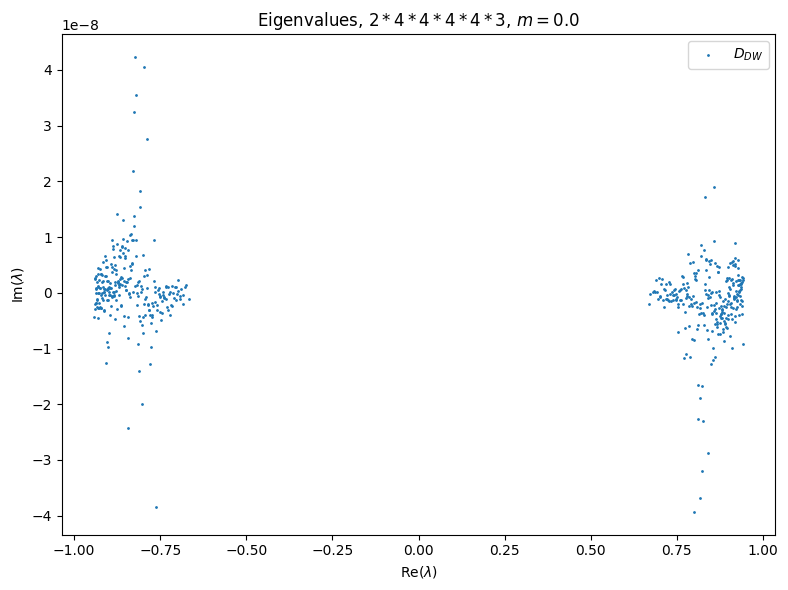

In [14]:
import numpy as np
import matplotlib.pyplot as plt


# 绘图
plt.figure(figsize=(8, 6))
plt.scatter(eigenvalues.get().real, eigenvalues.get().imag, s=1, label=r'$D_{DW}$')

plt.title(rf"Eigenvalues, ${int(params[define._LAT_X_]/define._LAT_P_)}*{params[define._LAT_Y_]}*{params[define._LAT_Z_]}*{params[define._LAT_T_]}*{define._LAT_S_}*{define._LAT_C_}$, $m = {argv[define._MASS_]}$")
plt.xlabel(r'Re$(\lambda)$')
plt.ylabel(r'Im$(\lambda)$')
plt.legend()
plt.tight_layout()
plt.show()


# End for pyqcu. (pass, don't run this)

In [15]:
# demo.end(set_ptrs=set_ptrs,params=params)